In [1]:
import os
import rasterio as rio
import numpy as np
import shapely
from shapely.geometry import Polygon, MultiPolygon, box
import pyproj
import geopandas as gpd
import matplotlib.pyplot as plt
import rioxarray as riox
import rasterio as rio
import xarray as xr
import netCDF4
from osgeo import gdal
import pandas as pd
from datetime import datetime
import dask.array
import matplotlib as mpl
from matplotlib.colors import TwoSlopeNorm, LogNorm
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.patches import Patch, Circle
import matplotlib.ticker as mticker
import sklearn
import importlib
import cartopy.crs as ccrs
import cartopy as ctp

import sys
sys.path.append('../')
import snowFun

In [2]:
importlib.reload(snowFun)

<module 'snowFun' from 'C:\\Users\\lzell\\OneDrive - Colostate\\Desktop\\AGVA\\scripts\\Figures\\..\\snowFun\\__init__.py'>

In [3]:
# define folder and file paths
folder_AGVA = os.path.join('C:',os.sep,'Users','lzell','OneDrive - Colostate','Desktop',"AGVA")
folder_dems = os.path.join(folder_AGVA, "DEMs", "time_varying_DEMs", "10m")
folder_class = os.path.join(folder_AGVA, 'classified images', 'S2_Classified_Cloudmasked_Merged')
folder_cloud = os.path.join(folder_AGVA, 'classified images', 'S2_Cloud_Merged')
folder_meta = os.path.join(folder_AGVA, "classified images", "meta csv", "S2")
folder_climate = os.path.join(folder_AGVA, "Climate")
folder_plotting = os.path.join(folder_AGVA, 'Plotting')

# open rgi
path_rgi = os.path.join(folder_AGVA, 'RGI', "rgi_2km_o3regions", "rgi_2km_o3regions.shp")
rgi_gdf = gpd.read_file(path_rgi, include_fields=['RGIId', 'geometry'])

# open the big data csv
path_data = os.path.join(folder_AGVA, 'Derived products', 'S2', 'Final_Data_Table.csv')
data_df = pd.read_csv(path_data)

# subset rgi to the glaciers we have data for
rgi_gdf = rgi_gdf[ rgi_gdf['RGIId'].isin(data_df['RGIId']) ]
# print(rgi_gdf.columns)

# merge columns
all_data_gdf = gpd.GeoDataFrame(pd.merge(data_df, rgi_gdf, on="RGIId"))

# replace -9999 with nan
all_data_gdf[all_data_gdf==-9999] = np.nan

# what columns are available?
print(all_data_gdf.shape)
print(all_data_gdf.columns.values)

(3002, 82)
['RGIId' 'GLIMSId' 'BgnDate' 'EndDate' 'CenLon' 'CenLat' 'O1Region'
 'O2Region' 'Area' 'Zmin' 'Zmax' 'Zmed' 'Slope' 'Aspect' 'Lmax' 'Status'
 'Connect' 'Form' 'TermType' 'Surging' 'Linkages' 'Name' 'O3Region'
 'O3_name' 'ela_2018' 'ela_2019' 'ela_2020' 'ela_2021' 'ela_2022'
 'aar_2018' 'aar_2019' 'aar_2020' 'aar_2021' 'aar_2022' 'off_glacier_2018'
 'off_glacier_2019' 'off_glacier_2020' 'off_glacier_2021'
 'off_glacier_2022' 'date_2018' 'date_2019' 'date_2020' 'date_2021'
 'date_2022' 'ela_avg_product' 'aar_avg_product' 'aar_infill_avg_product'
 'off_glacier_avg_product' 'percent_observed_average_product' 'dhdt_1520'
 'dhdt_1020' 'distance_from_ocean' 'hyps_ela' 'hyps_aar' 'hyps_aar_20'
 'hyps_aar_40' 'hyps_aar_60' 'hyps_aar_80' 'hyps_aar_100' 'hyps_aar_120'
 'hyps_aar_140' 'hyps_aar_160' 'hyps_aar_180' 'hyps_aar_200'
 'hyps_aar_220' 'hyps_aar_240' 'hyps_aar_260' 'hyps_aar_280'
 'hyps_aar_300' 'hyps_aar_320' 'hyps_aar_340' 'hyps_aar_360'
 'hyps_aar_380' 'hyps_aar_400' 'hyps_a

In [4]:
# open the 02region boundaries file
path_o2 = os.path.join(folder_AGVA, 'RGI', "subregion_boundaries", "RGI2000-v7.0-o2regions.shp")
o2_gdf = gpd.read_file(path_o2)
o2_gdf = o2_gdf[o2_gdf['o1region']=='01']
o2_gdf = o2_gdf[o2_gdf['o2region']!='01-01']
o2_gdf = o2_gdf.to_crs('epsg:3338')
o2_gdf['geometry'] = o2_gdf['geometry'].buffer(0)
o2_gdf

,o1region,o2region,full_name,long_code,geometry
1,01,01-02,Alaska Range (Wrangell/Kilbuck),01-02_alaska_range_wrangell_kilbuck,"POLYGON ((507640.645 1315152.700, 502668.024 1..."
2,01,01-03,Alaska Peninsula (Aleutians),01-03_alaska_peninsula_aleutians,"POLYGON ((-1536596.527 1081752.693, -1480375.3..."
3,01,01-04,West Chugach Mountains (Talkeetna),01-04_west_chugach_mountains_talkeetna,"POLYGON ((154033.906 975184.221, 139169.546 98..."
4,01,01-05,Saint Elias Mountains,01-05_saint_elias_mountains,"POLYGON ((516430.191 1311340.288, 526528.863 1..."
5,01,01-06,North Coast Ranges,01-06_north_coast_ranges,"POLYGON ((1257899.803 1333148.645, 1257912.240..."


In [5]:
# define a 16-color categorical color palette
# http://vrl.cs.brown.edu/color
from matplotlib.colors import ListedColormap
# hex_codes = ["#a0e3b7", "#b33c85", "#37b51f", "#b32df9", "#7e9b3d", "#333dcd", "#c0e15c", "#fe7dda", "#235e31", "#be0332", "#20d8fd", "#6c3640", "#21f0b6", "#ec7f6a", "#0362a0", "#f79302"]
# hex_codes = ["#3c2d80", "#609111", "#e30293", "#20502e", "#ec102f", "#219571", "#ce5d8e", "#3d8bb7", "#b94403", "#a143f9", "#604020", "#577cf5", "#ae783e", "#4b03a9", "#9679a6", "#154975"]
hex_codes = ["#097969","#FF3131","#CC5500","#D2042D","#880808","#EC5800","#1434A4","#3d8bb7","#0000FF","#577cf5","#FFD700","#C4B454","#DA70D6","#702963","#9679a6","#9F2B68"]
cmap_16 = ListedColormap(hex_codes)

In [6]:
# create list of o3region numbers, names, hex codes
numbers = np.arange(1,17)
names = [ all_data_gdf[all_data_gdf['O3Region']==n]['O3_name'].values[0] for n in numbers]
colors = [ hex_codes[n-1] for n in numbers ]
names[11] = 'St Elias Mountains'

o3_info_df = pd.DataFrame({'Number':numbers, 'Name':names, 'Color':colors})
o3_info_df

,Number,Name,Color
0,1,Aleutian Range,#097969
1,2,Northern Aleutian Range,#FF3131
2,3,Western Alaska Range,#CC5500
3,4,Central Alaska Range,#D2042D
4,5,Eastern Alaska Range,#880808
5,6,Wrangell Mountains,#EC5800
6,7,Talkeetna Mountains,#1434A4
7,8,Southern Kenai Mountains,#3d8bb7
8,9,Northern Kenai Mountains,#0000FF
9,10,Western Chugach Mountains,#577cf5


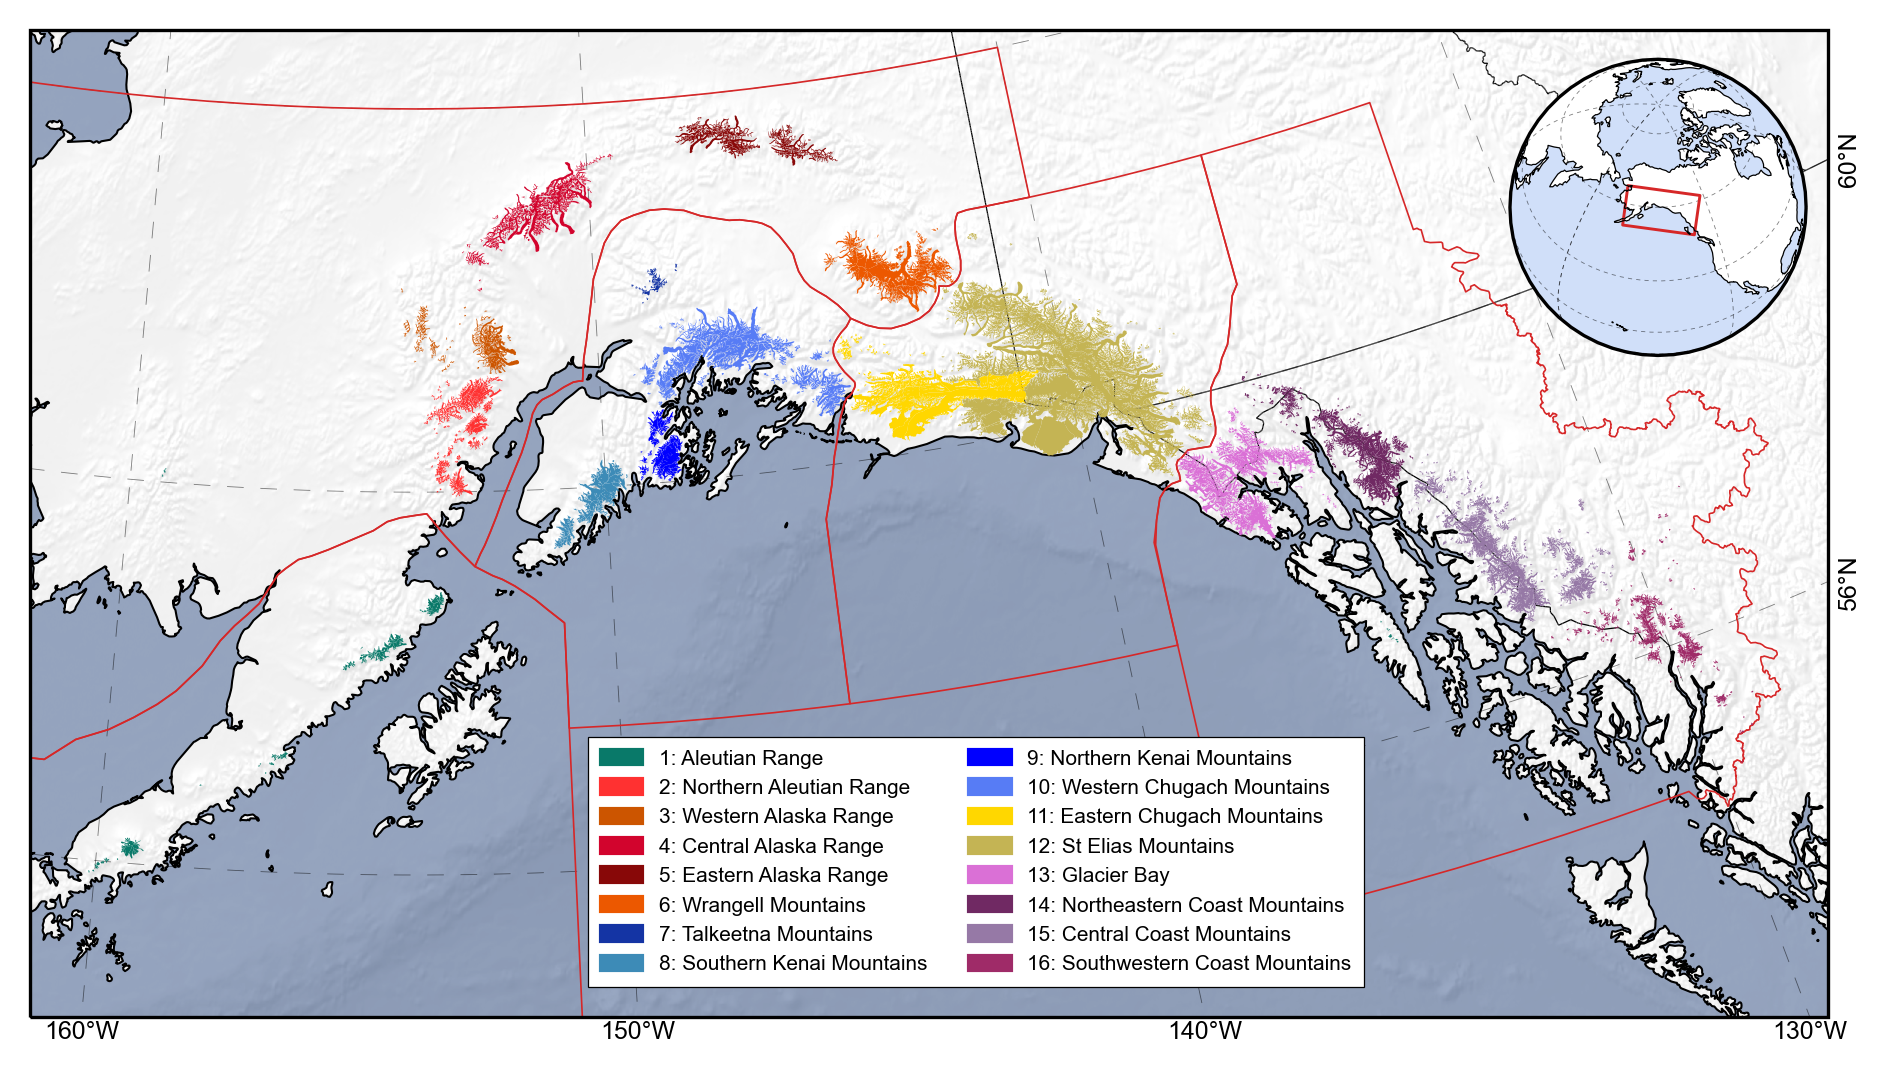

In [7]:
# define alaska albers projection
albers = ccrs.epsg(3338)


### Craft the figure
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'Arial'

# initiate
fig,axs = snowFun.create_base_map(hillshade=1, projection=albers)

# remove axis labels
axs.set_xticks([])
axs.set_yticks([])
axs.set_xlabel("")
axs.set_ylabel("")

# add lat/lon gridlines
gl = axs.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
              linestyle=(5,(20,20)), linewidth=0.2, color='0', alpha=0.5, xpadding=1)

# gridline edits
gl.top_labels=False
gl.left_labels=False
gl.xlabel_style = {'size':6, 'rotation':'horizontal', 'ha':'center'}
gl.ylabel_style = {'size':6, 'rotation':'vertical', 'ha':'center'}
gl.xlocator = mticker.FixedLocator([-160, -150, -140, -130])
gl.ylocator = mticker.FixedLocator([64, 60, 56])

# plot glaciers
all_data_gdf.plot(ax=axs, column='O3Region', cmap=cmap_16, vmin=1, vmax=16, zorder=10, legend=False,
                  legend_kwds={"location":'bottom', "fraction":0.02, 'pad':-0.15, "label":'O3Region'})

# plot o2region borders
o2_gdf.plot(ax=axs, facecolor='none', edgecolor='tab:red', linewidth=0.4, zorder=3)

# create legend
legend_elements = []
for idx,row in o3_info_df.iterrows():
    legend_elements.append( Patch(facecolor=row['Color'], edgecolor=row['Color'],
                                  label=f"{row['Number']}: {row['Name']}")
                          )
    
# place legend 
l = axs.legend(handles=legend_elements,
           ncols=2, fontsize=5, fancybox=False,
           framealpha=1, edgecolor='black', shadow=False,
           borderpad=0.6,
           loc='lower center', bbox_to_anchor=(0.523,0.020))

# legend border width
l.get_frame().set_linewidth(0.3)

### add inset axis for global context
inset_proj = ccrs.NearsidePerspective(central_longitude=-145, central_latitude=60, satellite_height=10000000) #35800000
ax_inset = axs.inset_axes( (0.75,0.67,0.3,0.3), transform=axs.transAxes,
                          projection=inset_proj)

# plot coastlines, ocean
ax_inset.add_feature(ctp.feature.OCEAN, facecolor='cornflowerblue', alpha=0.3)
ax_inset.coastlines(linewidth=0.3, zorder=2)

# add grid
glin = ax_inset.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
              linestyle=(5,(5,5)), linewidth=0.2, color='0', alpha=0.5, zorder=1)

# add box of the main map extent
bbox = box(minx=-450000, miny=500000, maxx=1661000, maxy=1652000)
ax_inset.add_geometries( bbox, crs=albers, facecolor="none", edgecolor="tab:red", linewidth=0.7)

# set axis outer box to be the top layer
for k, spine in axs.spines.items():
    spine.set_zorder(10)

# save
out_path = os.path.join(folder_AGVA, 'Figures', 'study area', 'study_area.png')
# plt.savefig(out_path, dpi=400, bbox_inches='tight', pad_inches=0.015)


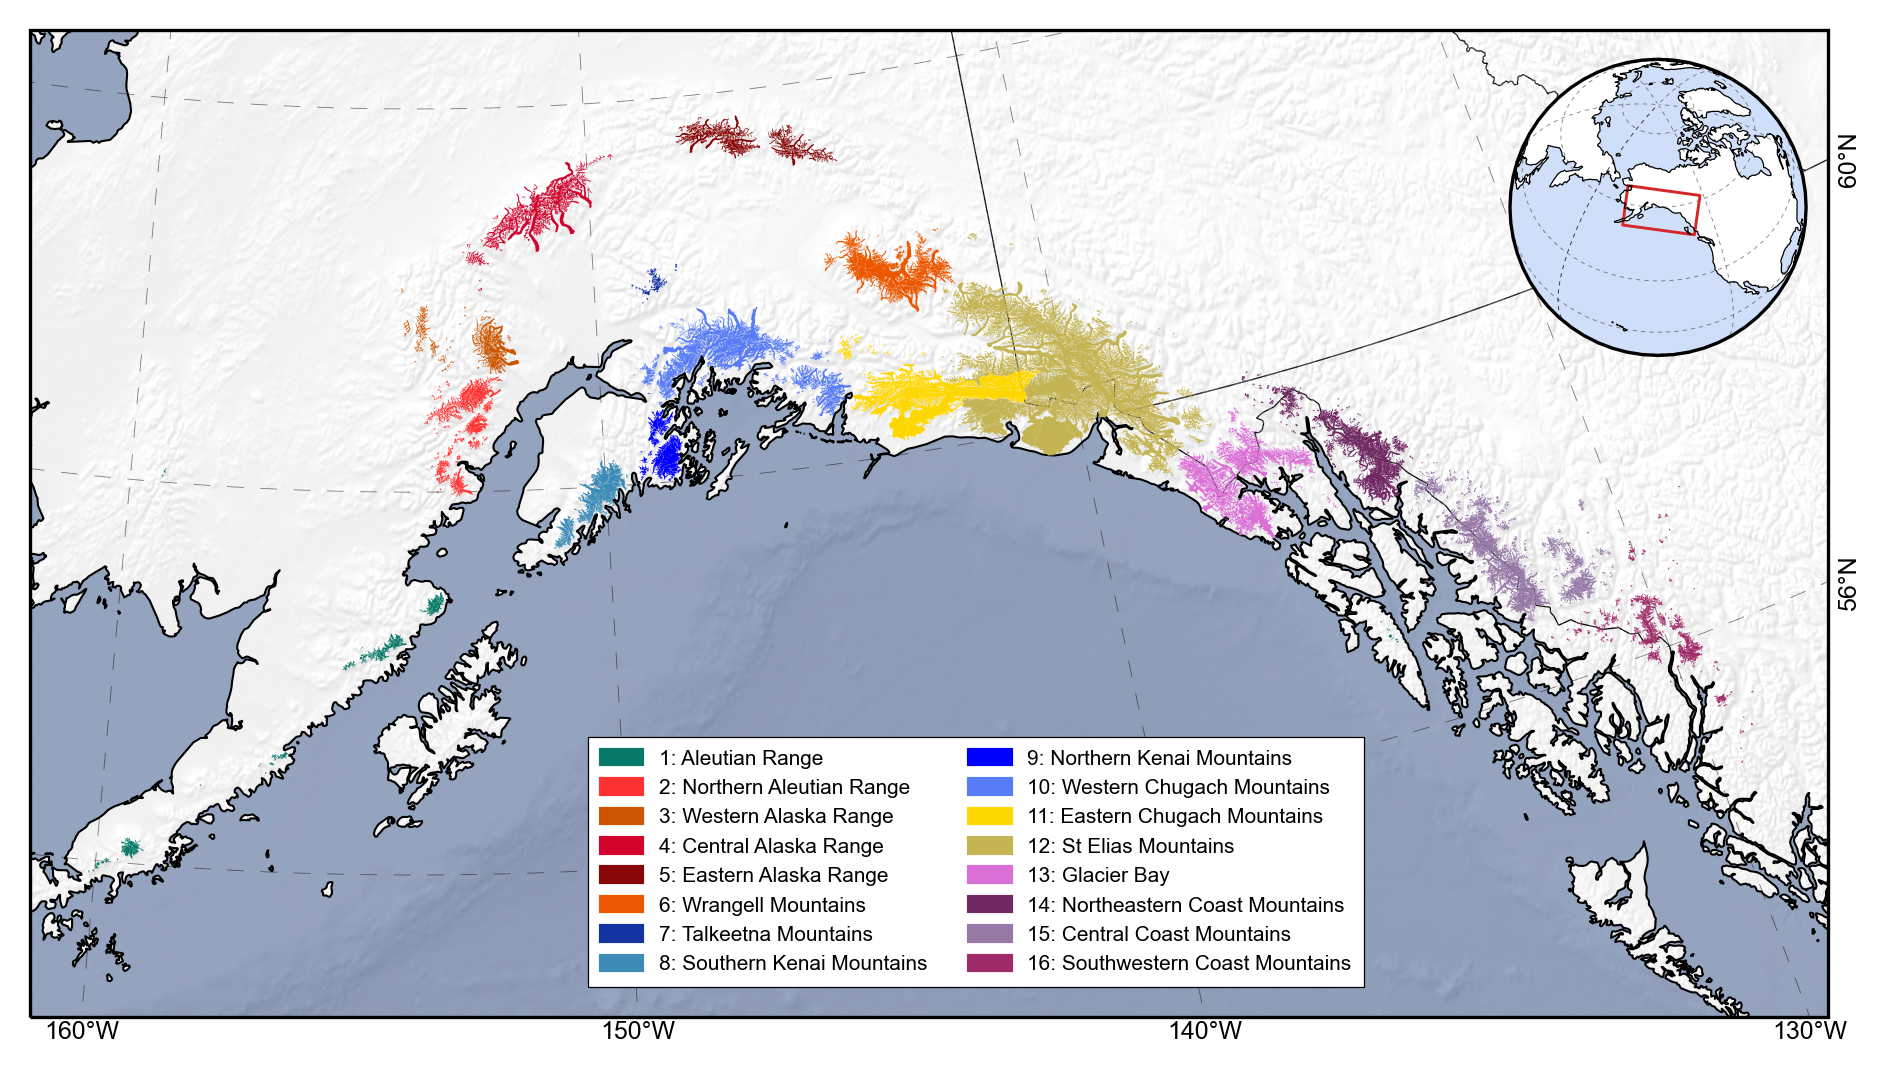

In [8]:
# define alaska albers projection
albers = ccrs.epsg(3338)


### Craft the figure
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'Arial'

# initiate
fig,axs = snowFun.create_base_map(hillshade=1, projection=albers)

# remove axis labels
axs.set_xticks([])
axs.set_yticks([])
axs.set_xlabel("")
axs.set_ylabel("")

# add lat/lon gridlines
gl = axs.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
              linestyle=(5,(20,20)), linewidth=0.2, color='0', alpha=0.5, xpadding=1)

# gridline edits
gl.top_labels=False
gl.left_labels=False
gl.xlabel_style = {'size':6, 'rotation':'horizontal', 'ha':'center'}
gl.ylabel_style = {'size':6, 'rotation':'vertical', 'ha':'center'}
gl.xlocator = mticker.FixedLocator([-160, -150, -140, -130])
gl.ylocator = mticker.FixedLocator([64, 60, 56])

# plot glaciers
all_data_gdf.plot(ax=axs, column='O3Region', cmap=cmap_16, vmin=1, vmax=16, zorder=10, legend=False,
                  legend_kwds={"location":'bottom', "fraction":0.02, 'pad':-0.15, "label":'O3Region'})

# plot o2region borders
# o2_gdf.plot(ax=axs, facecolor='none', edgecolor='tab:red', linewidth=0.4, zorder=3)

# create legend
legend_elements = []
for idx,row in o3_info_df.iterrows():
    legend_elements.append( Patch(facecolor=row['Color'], edgecolor=row['Color'],
                                  label=f"{row['Number']}: {row['Name']}")
                          )
    
# place legend 
l = axs.legend(handles=legend_elements,
           ncols=2, fontsize=5, fancybox=False,
           framealpha=1, edgecolor='black', shadow=False,
           borderpad=0.6,
           loc='lower center', bbox_to_anchor=(0.523,0.020))

# legend border width
l.get_frame().set_linewidth(0.3)

### add inset axis for global context
inset_proj = ccrs.NearsidePerspective(central_longitude=-145, central_latitude=60, satellite_height=10000000) #35800000
ax_inset = axs.inset_axes( (0.75,0.67,0.3,0.3), transform=axs.transAxes,
                          projection=inset_proj)

# plot coastlines, ocean
ax_inset.add_feature(ctp.feature.OCEAN, facecolor='cornflowerblue', alpha=0.3)
ax_inset.coastlines(linewidth=0.3, zorder=2)

# add grid
glin = ax_inset.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
              linestyle=(5,(5,5)), linewidth=0.2, color='0', alpha=0.5, zorder=1)

# add box of the main map extent
bbox = box(minx=-450000, miny=500000, maxx=1661000, maxy=1652000)
ax_inset.add_geometries( bbox, crs=albers, facecolor="none", edgecolor="tab:red", linewidth=0.7)

# set axis outer box to be the top layer
for k, spine in axs.spines.items():
    spine.set_zorder(10)

# save
out_path = os.path.join(folder_AGVA, 'Figures', 'study area', 'study_area_dis.png')
plt.savefig(out_path, dpi=400, bbox_inches='tight', pad_inches=0.015)
